In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import pymaster as nmt
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import nawrapper as nw
import nawrapper.maptools as maptools

In [3]:
nside = 512
lmax = nside * 3 - 1
B_ell = hp.sphtfunc.gauss_beam(np.deg2rad(0.5), lmax=lmax)

(0.0, 1.1)

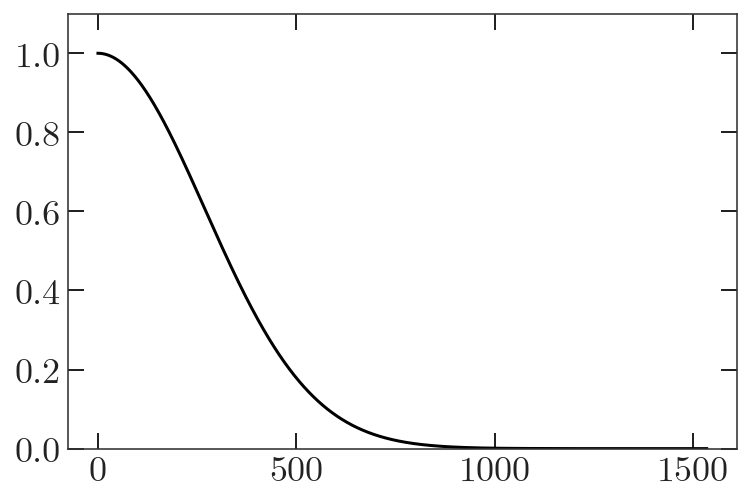

In [4]:
plt.plot(B_ell, '-')
plt.ylim(0.0, 1.1)

In this notebook we will assume a half-degree beam, and we let `synfast` apply the `pixwin` as well.

We create the *true* power and noise spectra.

In [5]:
from classy import Class
params = {'output': 'tCl pCl lCl', 'lensing':'yes'}
cosmo = Class()
cosmo.set(params); cosmo.compute()
cls = cosmo.lensed_cl(lmax)

In [6]:
for k in ['tt', 'te', 'ee']:
    cls[k] *= 1e12

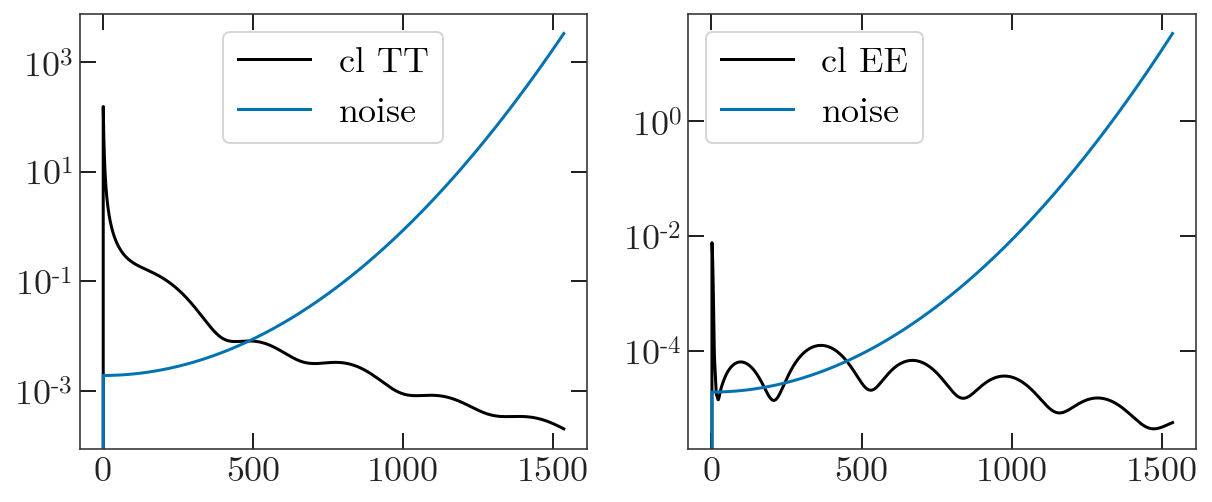

In [7]:
nltt = nw.get_Nl(theta_fwhm=20.0, sigma_T=150, l_max=lmax+1)
nlee = nltt / 100
# nl[0:2] = 0.0

fig, axes = plt.subplots(1, 2, figsize=(10,4))

axes[0].plot(cls['tt'], '-', label='cl TT')
axes[0].plot(nltt, '-', label='noise')
axes[0].set_yscale('log')
axes[0].legend()

axes[1].plot(cls['ee'], '-', label='cl EE')
axes[1].plot(nlee, '-', label='noise')
axes[1].set_yscale('log')
axes[1].legend()

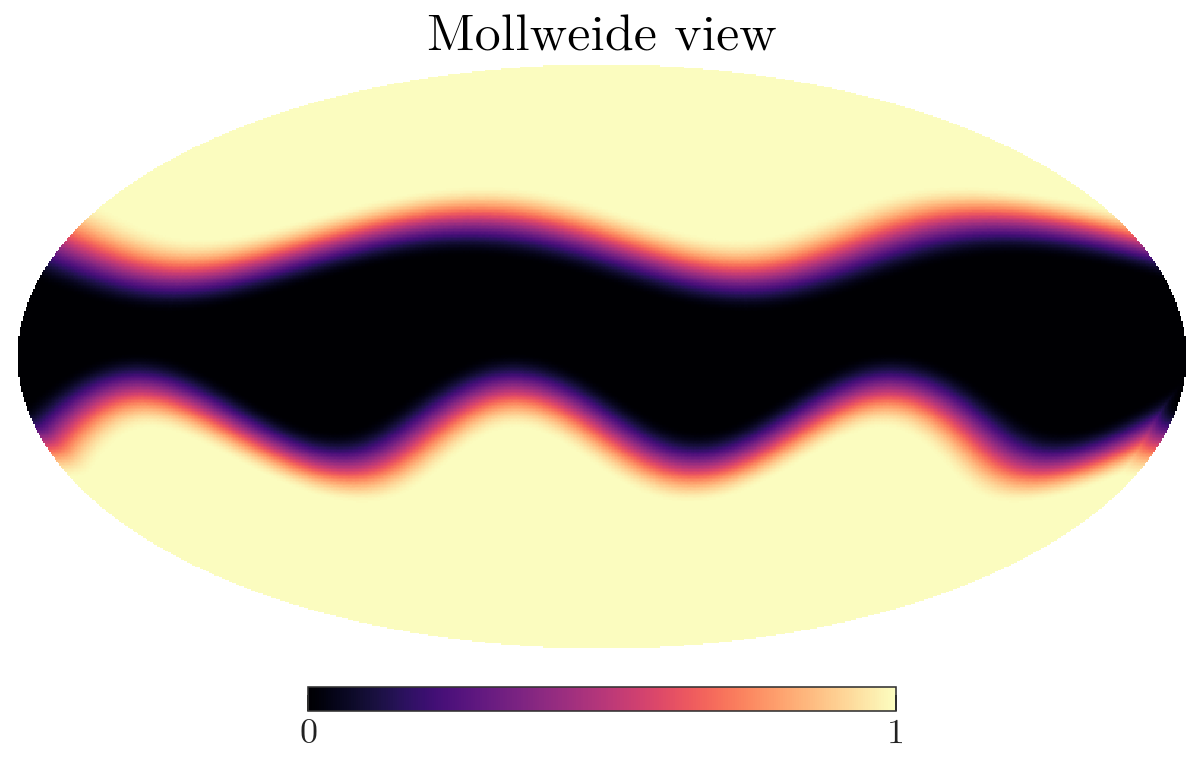

In [8]:
msk = np.zeros(hp.nside2npix(nside))
th, ph = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))
ph[np.where(ph > np.pi)[0]] -= 2 * np.pi
msk[np.where((th * (1 + 0.1 * np.sin(ph*3.1+0.1)) > 1.7) | 
             (th * (1 + 0.1 * np.sin(ph*2)) < 1.25) )[0]] = 1.
mask = nmt.mask_apodization(msk, 20.0, apotype='C2')
hp.mollview(mask)

In [9]:
bins=nmt.NmtBin(nside=nside, nlb=10)

In [10]:
def get_maps():
    # apply the pixel window transfer function (pixwin=True)
    #TT, EE, BB, TE, EB, TB
    m = hp.synfast(
        (cls['tt'], cls['ee'], cls['bb'], 
         cls['te'], np.zeros_like(cls['tt']), np.zeros_like(cls['tt'])), 
        nside, verbose=False, pixwin=True, new=True)
    
    n1 = hp.synfast(
        (nltt, nlee, nlee, 
         np.zeros_like(cls['tt']), np.zeros_like(cls['tt']), np.zeros_like(cls['tt'])), 
        nside, verbose=False, pixwin=True, new=True)
    n2 = hp.synfast(
        (nltt, nlee, nlee, 
         np.zeros_like(cls['tt']), np.zeros_like(cls['tt']), np.zeros_like(cls['tt'])), 
        nside, verbose=False, pixwin=True, new=True)
    
    m1_data = hp.smoothing(m + n1, beam_window=B_ell, verbose=False)
    m2_data = hp.smoothing(m + n2, beam_window=B_ell, verbose=False)
    
    m1 = nw.namap_hp(maps=(m1_data), masks=mask,
                  beams=B_ell, verbose=False, unpixwin=True)
    m2 = nw.namap_hp(maps=(m2_data), masks=mask,
                  beams=B_ell, verbose=False, unpixwin=True)
    return m1, m2

m1_, m2_ = get_maps()
mc = nw.mode_coupling(m1_, m2_, bins=bins)

In [11]:
def get_spec():
    m1, m2 = get_maps()
    return nw.compute_spectra(m1, m2, mc=mc, verbose=False)

In [13]:
from tqdm import tqdm
samples = [get_spec() for i in tqdm(range(200))]

  1%|          | 2/200 [00:35<55:56, 16.95s/it]

KeyboardInterrupt: 

In [ ]:
plt.plot(cls['tt'], label='true cl')
plt.plot(mc.lb, np.mean([s['TT'] for s in samples], axis=0)[:2*nside])

plt.legend()
plt.yscale('log')

In [ ]:
plt.plot(mc.lb, np.mean([s['TT'] for s in samples], axis=0) / cls['tt'][mc.lb.astype(int)])
plt.plot(cov.pixwin_temp)
plt.ylim(0.0, 1.1)

In [ ]:
m1, m2 = get_maps()
cov = nw.nacov(m1, m2, mc_11=mc, mc_12=mc, mc_22=mc, 
               signal={'TT':cls['tt'], 'EE':cls['ee'], 'TE':cls['te'], 'ET':cls['te']},
               noise={'T1T1':nltt, 'T2T2':nltt, 'E1E1':nlee, 'E2E2':nlee},
               smoothing_window=1, smoothing_polyorder=0)
cov.compute()
# cov.compute_subcovmat((0,0,0,0))

In [ ]:
plt.plot(cov.Cl11['TT'], '-', label='estimated noise (map 1)')
plt.plot(cov.Cl12['TT'], '-', label='estimated noise (map 1)')
plt.yscale('log')

In [ ]:
plt.figure(figsize=(8,6))

plt.plot(cls['tt'], '--', label='true cl')
plt.plot(nltt, '-', label='true noise', alpha=0.5, lw=6)
plt.plot(cov.noise['T1T1'], '-', label='estimated noise (map 1)')
plt.plot(mc.lb, np.std([s['TT'] for s in samples], axis=0)[:2*nside], '-', lw=4, alpha=0.5, label='sample err')
plt.plot(mc.lb, np.sqrt(np.diag(cov.covmat['TTTT'])), "-", label='analytic cov err')
plt.legend()
plt.yscale('log')

In [ ]:
plt.plot(cov.lb, np.std([s['TT'] for s in samples], axis=0) / 
         np.sqrt(np.diag(cov.covmat['TTTT'])) )
plt.ylim(0.8,1.1)

In [ ]:
plt.figure(figsize=(8,6))

plt.plot(cls['ee'], '--', label='true cl')

plt.plot(nlee, '-', label='true noise', alpha=0.5, lw=6)
plt.plot(cov.noise['E1E1'], '-', label='estimated noise (map 1)')
plt.plot(mc.lb, np.std([s['EE'] for s in samples], axis=0)[:2*nside], '-', lw=4, alpha=0.5, label='sample err')
plt.plot(mc.lb, np.sqrt(np.diag(cov.covmat['EEEE'])), "-", label='analytic cov err')
plt.legend()
plt.yscale('log')

In [ ]:
plt.plot(cov.lb, np.std([s['EE'] for s in samples], axis=0) / 
         np.sqrt(np.diag(cov.covmat['EEEE'])) )
plt.ylim(0.0,1.2)

# Off-Diagonal Blocks

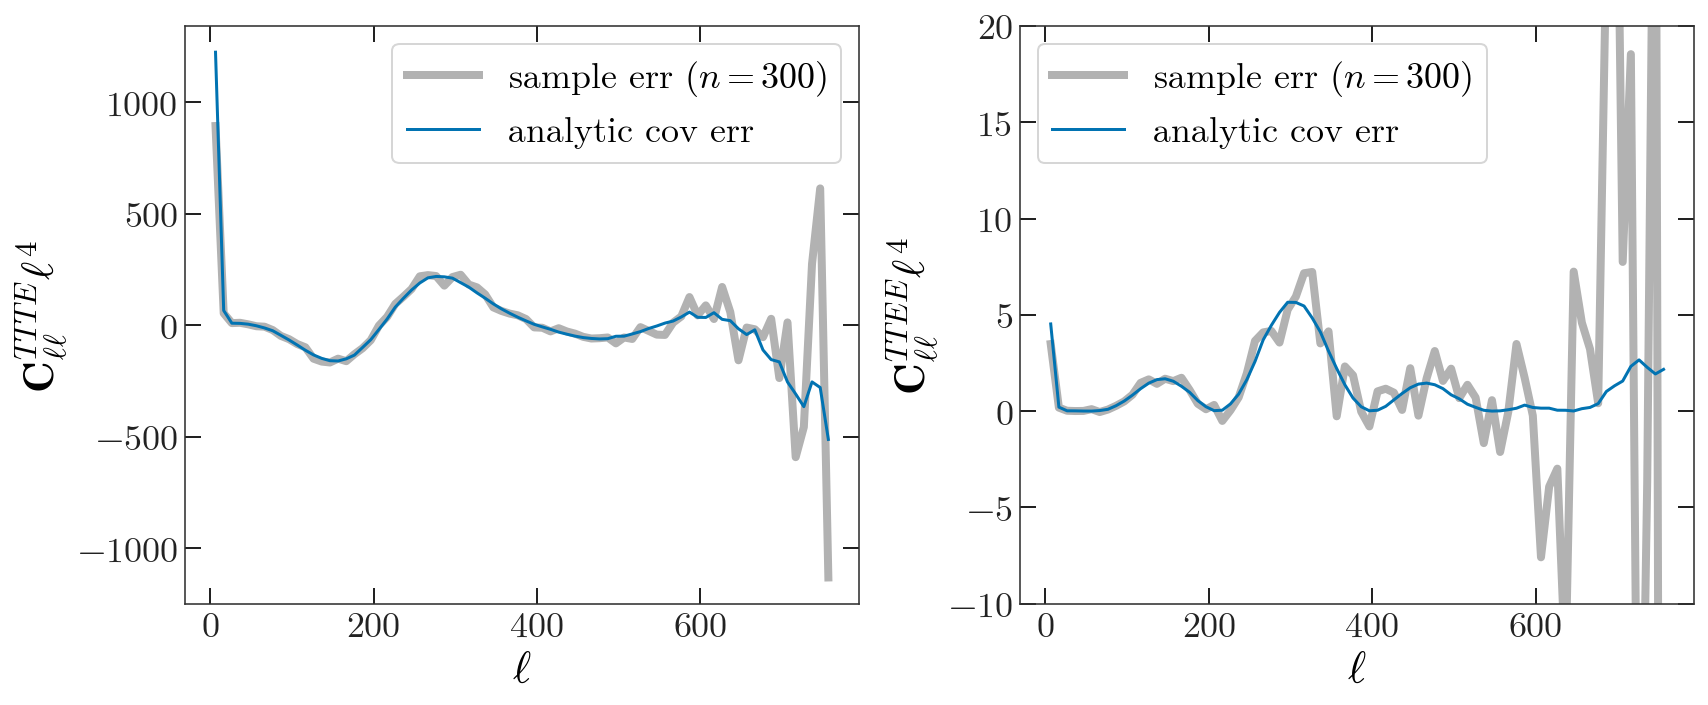

In [261]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

sampstack = np.hstack( [[s['TT'] for s in samples], [s['TE'] for s in samples]] ).T
subcov = np.cov(sampstack)[:-76, -76:]
ax[0].plot(mc.lb, np.diag(subcov) * mc.lb**4, '-', lw=4, alpha=0.3, label=r'sample err $(n=300)$')
ax[0].plot(mc.lb, np.diag(cov.covmat['TTTE']) * mc.lb**4, "-", label='analytic cov err')
ax[0].legend()
ax[0].set_ylabel(r'$\mathbf{C}_{\ell \ell}^{TTTE} \ell^4$')
ax[0].set_xlabel(r'$\ell$')

sampstack = np.hstack( [[s['TT'] for s in samples], [s['EE'] for s in samples]] ).T
subcov = np.cov(sampstack)[:-76, -76:]
ax[1].plot(mc.lb, np.diag(subcov) * mc.lb**4, '-', lw=4, alpha=0.3, label=r'sample err $(n=300)$')
ax[1].plot(mc.lb, np.diag(cov.covmat['TTEE']) * mc.lb**4, "-", label='analytic cov err')
ax[1].legend()
ax[1].set_ylabel(r'$\mathbf{C}_{\ell \ell}^{TTEE} \ell^4$')
ax[1].set_xlabel(r'$\ell$')
ax[1].set_ylim(-10, 20)
plt.tight_layout()
# plt.yscale('log')

# Different Noise Levels in Each Map

In [23]:
def get_maps_different():
    # apply the pixel window transfer function (pixwin=True)
    m = hp.synfast(B_ell[:lmax]**2 * cl, nside, verbose=False, pixwin=True)
    n1 = hp.synfast(B_ell[:lmax]**2 * nl, nside, verbose=False, pixwin=True)
    n2 = hp.synfast(B_ell[:lmax]**2 * (nl**1.2),nside, verbose=False, pixwin=True)
    m1 = nw.namap_hp(maps=(m + n1, None, None), 
                  beams=B_ell,
                  verbose=False, unpixwin=True)
    m2 = nw.namap_hp(maps=(m + n2, None, None), 
                  beams=B_ell,
                  verbose=False, unpixwin=True)
    return m1, m2

def get_spec_different():
    m1, m2 = get_maps_different()
    return nw.compute_spectra(m1, m2, lmax=lmax, verbose=False)['TT']

In [24]:
m1, m2 = get_maps_different()

In [25]:
from tqdm import tqdm
samples = [get_spec_different() for i in tqdm(range(50))]

100%|██████████| 50/50 [00:41<00:00,  1.20it/s]


In [26]:
m1, m2 = get_maps_different()

mc = nw.mode_coupling(m1, m2, bins=nw.get_unbinned_bins(lmax-1, nside=nside))
cov = nw.nacov(m1, m2, mc_11=mc, mc_12=mc, mc_22=mc)
cov.compute()

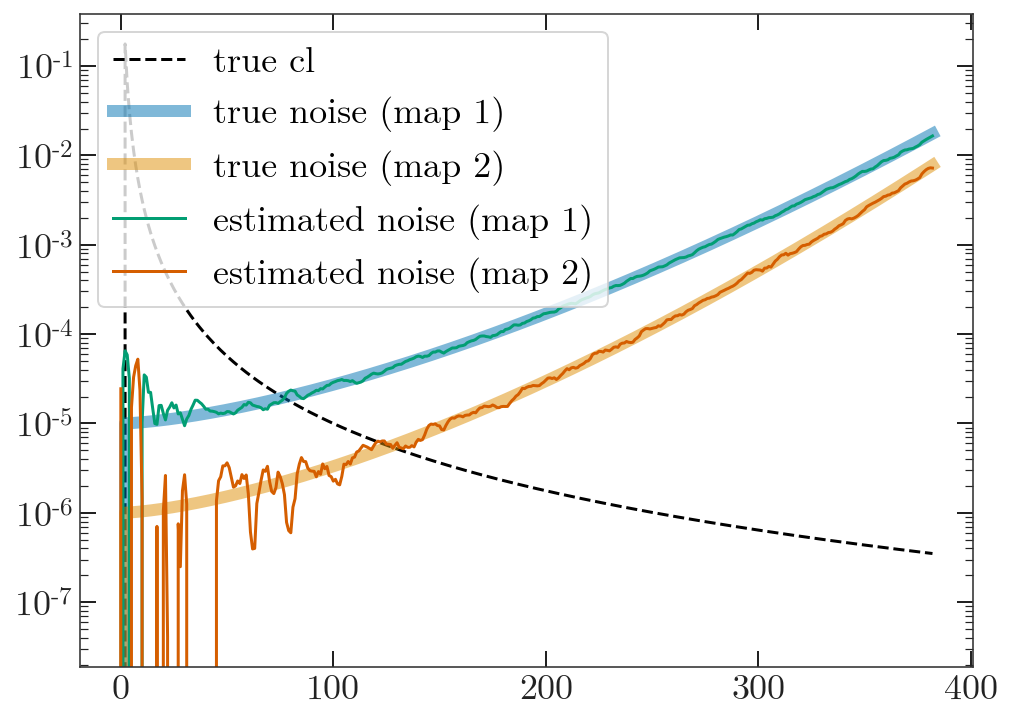

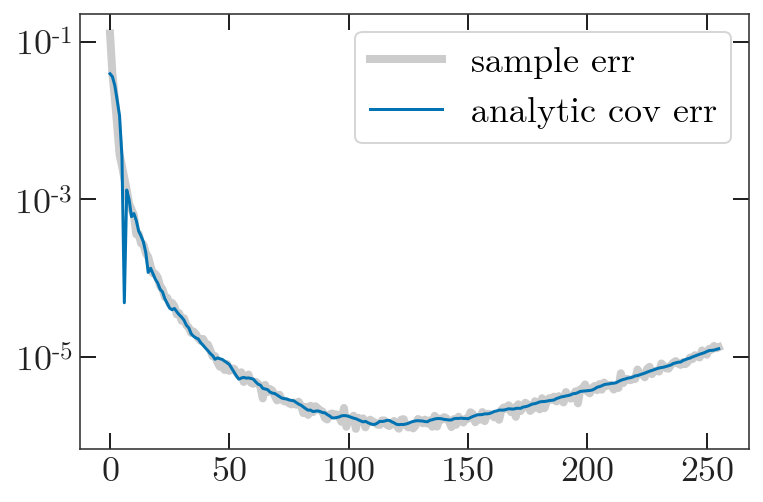

In [27]:
plt.figure(figsize=(8,6))

plt.plot(cl, '--', label='true cl')
plt.plot(nl, '-', label='true noise (map 1)', alpha=0.5, lw=6)
plt.plot(nl**1.2, '-', label='true noise (map 2)', alpha=0.5, lw=6)
plt.plot(cov.noise['T1T1'], '-', label='estimated noise (map 1)')
plt.plot(cov.noise['T2T2'], '-', label='estimated noise (map 2)')
plt.legend()
plt.yscale('log')

plt.figure()
plt.plot( np.std(samples, axis=0)[:2*nside], '-', lw=4, alpha=0.2, label='sample err')
plt.plot( np.sqrt(np.diag(cov.covmat['TTTT']))[:2*nside], "-", label='analytic cov err')
plt.legend()
plt.yscale('log')